In [3]:
import numpy as np
import math
import random
from typing import List, Dict, Any

# ============================
# GLOBAL CONFIG
# ============================

INSTANCE_PATH = r"gecco19-thief\src\main\resources\fnl4461-n4460.txt"

# TSP / 2-OPT
CAND_K = 100
TWO_OPT_PASSES = 5000

# EVOLUTION
POP_SIZE = 200
GENERATIONS = 500
TOURN_K = 7

NUM_GREEDIES = 75      # tune to 2-8 depending runtime

HC_STEPS = 100  # tune later
TOUR_2OPT_STEPS = 100  # keep small or you'll regret it

# ITEM SEEDING PARAMETERS
CAP_FACTORS = [0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
GAMMAS = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30]
HEUR_MODES = ["suffix", "profit_adj", "time_ratio"]
MUT_RATE = 0.003
LIGHT_MUT_RATE = 0.02

GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# HYPERVOLUME (same reference used in your comparisons)
IDEAL = (185359.0, -645150.0)
NADIR = (442464.0, 0.0)

MAX_ARCHIVE = 50          # same behaviour as second file (cap via crowding)
archive_pop = []          # stores solutions
archive_objs = []         # stores (T,P,W)

# Global elites across all generations
bestP = -1.0
bestP_sol = None

bestT = None
bestT_sol = None


# ===============================================================
# PARSE INSTANCE
# ===============================================================
def parse_ttp(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    dim = num_items = None
    capacity = v_min = v_max = None
    edge_type = None

    i = 0
    while i < len(lines):
        L = lines[i]
        if L.startswith("DIMENSION"):
            dim = int(L.split(":")[1])
        elif L.startswith("NUMBER OF ITEMS"):
            num_items = int(L.split(":")[1])
        elif L.startswith("CAPACITY OF KNAPSACK"):
            capacity = float(L.split(":")[1])
        elif L.startswith("MIN SPEED"):
            v_min = float(L.split(":")[1])
        elif L.startswith("MAX SPEED"):
            v_max = float(L.split(":")[1])
        elif L.startswith("EDGE_WEIGHT_TYPE"):
            edge_type = L.split(":")[1].strip()
        elif L.startswith("NODE_COORD_SECTION"):
            break
        i += 1

    i += 1
    coords = np.zeros((dim, 2), float)
    for k in range(dim):
        idx, x, y = lines[i + k].split()
        coords[int(idx) - 1] = [float(x), float(y)]
    i += dim

    while "ITEMS SECTION" not in lines[i]:
        i += 1
    i += 1

    items = []
    for j in range(num_items):
        parts = lines[i + j].split()
        profit = float(parts[1])
        weight = float(parts[2])
        city = int(parts[3]) - 1
        items.append((profit, weight, city))

    return {
        "dim": dim,
        "coords": coords,
        "items": items,
        "capacity": capacity,
        "v_min": v_min,
        "v_max": v_max,
        "edge_type": edge_type,
    }


# ===============================================================
# TSP (Nearest Neighbour + 2-opt with candidate lists)
# ===============================================================
def nn_tour(coords: np.ndarray) -> np.ndarray:
    n = len(coords)
    unvis = np.ones(n, dtype=bool)
    tour = np.empty(n, int)
    cur = 0

    for t in range(n):
        tour[t] = cur
        unvis[cur] = False
        if t == n - 1:
            break
        dx = coords[unvis, 0] - coords[cur, 0]
        dy = coords[unvis, 1] - coords[cur, 1]
        nxt = np.where(unvis)[0][np.argmin(dx * dx + dy * dy)]
        cur = nxt

    return tour


def compute_dists(order: np.ndarray, coords: np.ndarray) -> np.ndarray:
    n = len(order)
    out = np.empty(n, float)
    for i in range(n):
        a = order[i]
        b = order[(i + 1) % n]
        d = math.sqrt(((coords[a] - coords[b]) ** 2).sum())
        out[i] = math.ceil(d)
    return out


def city_dist(a: int, b: int, coords: np.ndarray) -> float:
    dx = coords[a, 0] - coords[b, 0]
    dy = coords[a, 1] - coords[b, 1]
    return math.ceil(math.hypot(dx, dy))


def build_candidate_lists(coords: np.ndarray, k=CAND_K):
    """
    Build K nearest-neighbour candidate list per city using sklearn KD-tree.

    Returns list of length n: cand[i] is list of neighbour city indices for city i.
    If sklearn is unavailable, returns None and we skip 2-opt.
    """
    n = len(coords)
    try:
        from sklearn.neighbors import NearestNeighbors
    except ImportError:
        print("[WARN] sklearn not available; skipping candidate-based 2-opt.")
        return None

    print(f"[INFO] Building candidate lists with k={k} using sklearn...")
    nn = NearestNeighbors(n_neighbors=min(k + 1, n), algorithm="kd_tree")
    nn.fit(coords)
    _, inds = nn.kneighbors(coords)

    cand = []
    for i in range(n):
        neigh = [j for j in inds[i] if j != i]
        cand.append(neigh[:k])
    return cand


def two_opt_with_candidates(order: np.ndarray,
                            coords: np.ndarray,
                            cand_lists,
                            max_passes=TWO_OPT_PASSES) -> np.ndarray:

    if cand_lists is None:
        return order

    n = len(order)
    pos = np.empty(n, int)
    for idx, city in enumerate(order):
        pos[city] = idx

    # track best found so far for print purposes ONLY
    best_len = sum(city_dist(order[i], order[(i+1)%n], coords) for i in range(n))

    for p in range(max_passes):
        improved = False

        for i in range(n - 1):
            a = order[i]
            b = order[i + 1]

            for c in cand_lists[a]:
                j = pos[c]
                if j <= i + 1 or j >= n - 1:
                    continue

                d = order[j + 1]

                old_len = city_dist(a, b, coords) + city_dist(c, d, coords)
                new_len = city_dist(a, c, coords) + city_dist(b, d, coords)

                if new_len < old_len:
                    order[i+1:j+1] = order[i+1:j+1][::-1]

                    for t in range(i+1, j+1):
                        pos[order[t]] = t

                    improved = True
                    curr_len = sum(city_dist(order[k], order[(k+1)%n], coords) for k in range(n))
                    best_len = min(best_len, curr_len)
                    break

            if improved:
                break

        if not improved:
            print(f"[2-OPT] Early stop at pass {p+1}, no improvement.")
            break

        # print every 50 iterations
        if (p+1) % 50 == 0:
            print(f"[2-OPT] Pass {p+1}  |  Best length so far = {best_len}")

    return order



# ===============================================================
# PRECOMPUTE ITEM DATA
# ===============================================================
def prep_items(inst, order, dists):
    n = inst["dim"]
    city_pos = np.empty(n, int)
    for pos, city in enumerate(order):
        city_pos[city] = pos

    suffix = np.empty(len(dists))
    run = 0.0
    for i in reversed(range(len(dists))):
        run += dists[i]
        suffix[i] = run

    recs = []
    for idx, (p, w, c) in enumerate(inst["items"]):
        pos = city_pos[c]
        recs.append({
            "index": idx,
            "city": c,
            "pos": pos,
            "profit": p,
            "weight": w,
            "suffix": float(suffix[pos])
        })

    return recs, float(suffix[0])


# ===============================================================
# EVALUATION
# ===============================================================
def evaluate(inst, order, dists, recs, chosen):
    cap = inst["capacity"]
    vmin = inst["v_min"]
    vmax = inst["v_max"]

    city_w = np.zeros(len(order), float)
    city_p = np.zeros(len(order), float)

    for r, ch in zip(recs, chosen):
        if ch:
            city_w[r["pos"]] += r["weight"]
            city_p[r["pos"]] += r["profit"]

    alpha = (vmax - vmin) / cap

    W = 0.0
    T = 0.0
    P = 0.0

    for i in range(len(order)):
        W += city_w[i]
        v = vmax - alpha * W
        if v < vmin:
            v = vmin
        T += dists[i] / v
        P += city_p[i]

    return T, P, W


# ===============================================================
# CAPACITY REPAIR
# ===============================================================
def repair_to_capacity(chosen, recs, capacity):
    """
    Ensure total weight <= capacity by dropping worst profit/weight items.
    """
    weights = np.array([r["weight"] for r in recs], dtype=float)
    profits = np.array([r["profit"] for r in recs], dtype=float)

    chosen = list(chosen)
    total_w = float((weights * np.array(chosen, dtype=float)).sum())

    if total_w <= capacity:
        return chosen

    chosen_idx = [i for i, flag in enumerate(chosen) if flag]
    chosen_idx.sort(key=lambda i: profits[i] / weights[i])  # worst first

    for i in chosen_idx:
        if total_w <= capacity:
            break
        chosen[i] = False
        total_w -= weights[i]

    return chosen


# ===============================================================
# GREEDY SEEDING MODES
# ===============================================================

def build_seed(inst, order, dists, recs, total_dist):
    mode = random.choice(HEUR_MODES)
    gamma = random.choice(GAMMAS)
    power = random.choice([0.5, 1.0, 2.0])
    cap_target = random.choice(CAP_FACTORS) * inst["capacity"]

    if mode == "suffix":
        for r in recs:
            r["score"] = (r["suffix"] / total_dist) ** power

    elif mode == "profit_adj":
        for r in recs:
            adj = r["weight"] * (1.0 + gamma * (r["suffix"] / total_dist))
            r["score"] = r["profit"] / adj

    else:
        alpha = (inst["v_max"] - inst["v_min"]) / inst["capacity"]
        for r in recs:
            dv = alpha * r["weight"]
            v_before = inst["v_max"]
            v_after = max(inst["v_max"] - dv, inst["v_min"])
            dt = r["suffix"] / v_after - r["suffix"] / v_before
            if dt <= 0:
                dt = 1e-6
            r["score"] = r["profit"] / dt

    idxs = sorted(range(len(recs)), key=lambda i: recs[i]["score"], reverse=True)

    chosen = [False] * len(recs)
    W = 0.0
    for i in idxs:
        w = recs[i]["weight"]
        if W + w <= cap_target:
            chosen[i] = True
            W += w

    chosen = repair_to_capacity(chosen, recs, inst["capacity"])
    return chosen


# ===============================================================
# MUTATION / CROSSOVER
# ===============================================================
def mutate(chosen, rate=MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def light_mutate(chosen, rate=LIGHT_MUT_RATE):
    out = chosen[:]
    for i in range(len(out)):
        if random.random() < rate:
            out[i] = not out[i]
    return out


def crossover(a, b):
    n = len(a)
    cut = random.randint(0, n - 1)
    return a[:cut] + b[cut:]


# ===============================================================
# NSGA-II
# ===============================================================
def dominates(A, B):
    t1, p1, _ = A
    t2, p2, _ = B
    return (t1 <= t2 and p1 >= p2) and (t1 < t2 or p1 > p2)


def pareto_rank(objs):
    n = len(objs)
    dom_counts = [0] * n
    dominated_by = [[] for _ in range(n)]
    fronts = [[]]

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if dominates(objs[i], objs[j]):
                dominated_by[i].append(j)
            elif dominates(objs[j], objs[i]):
                dom_counts[i] += 1
        if dom_counts[i] == 0:
            fronts[0].append(i)

    k = 0
    while fronts[k]:
        nxt = []
        for i in fronts[k]:
            for j in dominated_by[i]:
                dom_counts[j] -= 1
                if dom_counts[j] == 0:
                    nxt.append(j)
        k += 1
        fronts.append(nxt)

    return fronts[:-1]

def crowding_distance(front_indices, objs):
    """
    front_indices: list of indices (into objs) belonging to one Pareto front
    objs: list of (time, profit, weight)

    Returns: dict {idx: distance}
    """
    if not front_indices:
        return {}

    # init distances
    dist = {i: 0.0 for i in front_indices}

    # use only time (index 0, minimise) and profit (index 1, maximise)
    num_obj = 2
    for m in range(num_obj):
        vals = [(i, objs[i][m]) for i in front_indices]

        if m == 0:
            # time: smaller is better → sort ascending
            vals.sort(key=lambda x: x[1])
        else:
            # profit: larger is better → sort descending
            vals.sort(key=lambda x: x[1], reverse=True)

        v_min = vals[0][1]
        v_max = vals[-1][1]
        if v_max == v_min:
            # no spread on this dimension
            continue

        # boundary points get infinite crowding
        dist[vals[0][0]]  = float("inf")
        dist[vals[-1][0]] = float("inf")

        # internal points
        for k in range(1, len(vals) - 1):
            i_prev, v_prev = vals[k - 1]
            i_curr, v_curr = vals[k]
            i_next, v_next = vals[k + 1]
            incr = (v_next - v_prev) / (v_max - v_min)
            dist[i_curr] += incr

    return dist

# ===============================================================
# DIVERSITY-AWARE MATING SCORES + TOURNAMENT SELECTION
# ===============================================================
def compute_mating_scores(objs,
                          alpha=0.5,  # Pareto rank weight
                          beta=0.3,   # crowding weight
                          gamma=0.2   # sparsity weight
                          ):
    """
    objs: list of (T, P, W)
    Returns: list[float] score per individual, higher = more likely to mate.
    """

    n = len(objs)
    if n == 0:
        return []

    # ---------- 1) Pareto rank score (front 0 best) ----------
    fronts = pareto_rank(objs)  # list of fronts, each is list of indices
    rank_score = [0.0] * n
    if len(fronts) == 1:
        # everyone same front
        for i in fronts[0]:
            rank_score[i] = 1.0
    else:
        max_front = max(1, len(fronts) - 1)
        for rank, front in enumerate(fronts):
            val = 1.0 - (rank / max_front)   # front 0 → 1.0, last front → ~0.0
            for i in front:
                rank_score[i] = val

    # ---------- 2) Crowding score over whole pop ----------
    idxs = list(range(n))
    cd = crowding_distance(idxs, objs)  # dict {idx: dist}
    cd_vec = [cd.get(i, 0.0) for i in range(n)]

    # normalise crowding, keep boundary INF higher than others
    finite_vals = [v for v in cd_vec if math.isfinite(v)]
    if not finite_vals:
        cd_norm = [0.0] * n
    else:
        max_fin = max(finite_vals)
        if max_fin <= 0.0:
            cd_norm = [0.0] * n
        else:
            cd_norm = []
            for v in cd_vec:
                if not math.isfinite(v):
                    cd_norm.append(1.1)  # slightly above max finite
                else:
                    cd_norm.append(v / max_fin)

    # ---------- 3) Sparsity: distance from centroid in (T,P) ----------
    times = np.array([o[0] for o in objs], dtype=float)
    profits = np.array([o[1] for o in objs], dtype=float)

    t_bar = float(times.mean())
    p_bar = float(profits.mean())

    div_radius = np.sqrt((times - t_bar) ** 2 + (profits - p_bar) ** 2)
    max_r = float(div_radius.max()) if n > 0 else 0.0
    if max_r <= 0.0:
        div_norm = [0.0] * n
    else:
        div_norm = [float(r / max_r) for r in div_radius]

    # ---------- 4) Combine into final score ----------
    scores = []
    for i in range(n):
        s = (alpha * rank_score[i] +
             beta  * cd_norm[i] +
             gamma * div_norm[i])
        scores.append(s)

    return scores


def tournament_select(pop, scores, k=TOURN_K):
    """
    k-way tournament on 'scores', returns *one individual* from pop.
    Higher score = more likely to win.
    """
    n = len(pop)
    if n == 0:
        raise ValueError("tournament_select called with empty population")
    k = min(k, n)

    cand = random.sample(range(n), k)
    best_idx = max(cand, key=lambda i: scores[i])
    return pop[best_idx]


# ===============================================================
# EVOLUTION LOOP (with 2+2 tail elites per generation)
# ===============================================================
def run_evo(inst, order, dists, recs, total_dist,
            gens=GENERATIONS, pop_size=POP_SIZE):

    global archive_pop, archive_objs, bestP, bestP_sol, bestT, bestT_sol


    # initial population
    pop = [build_seed(inst, order, dists, recs, total_dist)
           for _ in range(pop_size)]
    objs = [evaluate(inst, order, dists, recs, c) for c in pop]

    for g in range(gens):
        # update global best profit & best time from current population
        for sol, (T, P, W) in zip(pop, objs):
            if P > bestP:
                bestP = P
                bestP_sol = sol[:]
            if bestT is None or T < bestT:
                bestT = T
                bestT_sol = sol[:]

        print(f"[GEN {g:4d}] min_time={min(o[0] for o in objs):.1f}  max_profit={max(o[1] for o in objs):.0f}")


        # -------------------------------------------------------
        # 1) IDENTIFY ELITES FROM CURRENT POPULATION
        #    - 2 fastest (smallest time)
        #    - 2 richest (largest profit)
        # -------------------------------------------------------
        num_tail_elites = 2

        # indices sorted by time (ascending: fastest first)
        idx_by_time = sorted(range(len(objs)), key=lambda i: objs[i][0])
        # indices sorted by profit (descending: richest first)
        idx_by_profit = sorted(range(len(objs)), key=lambda i: objs[i][1], reverse=True)

        elite_indices = []

        # take 2 fastest
        for i in idx_by_time[:num_tail_elites]:
            if i not in elite_indices:
                elite_indices.append(i)

        # take 2 richest
        for i in idx_by_profit[:num_tail_elites]:
            if i not in elite_indices:
                elite_indices.append(i)

        elite_solutions = [pop[i][:] for i in elite_indices]
        elite_objs      = [objs[i]   for i in elite_indices]

        # ==========================
        # PARALLEL HILL-CLIMB ELITES
        # ==========================

        for e in range(len(elite_solutions)):
            sol = elite_solutions[e][:]
            sol = repair_to_capacity(sol, recs, inst["capacity"])  # <<< INSERTED LINE
            best_T, best_P, best_W = elite_objs[e]

            for _ in range(HC_STEPS):
                j = random.randrange(len(sol))

                new = sol[:]               # work on a copy
                new[j] = not new[j]        # flip one item
                new = repair_to_capacity(new, recs, inst["capacity"])
                T2,P2,W2 = evaluate(inst,order,dists,recs,new)

                # accept only capacity-safe improvements
                if (T2 < best_T and P2 >= best_P*0.95) or (P2 > best_P and T2 <= best_T*1.05):
                    sol = new[:]           # commit full improved candidate
                    best_T,best_P,best_W = T2,P2,W2

            elite_solutions[e] = sol
            elite_objs[e]      = (best_T,best_P,best_W)


        # ==========================
        # 2-OPT TOUR HILLCLIMB FOR ELITES
        # ==========================

        for e in range(len(elite_solutions)):
            sol = elite_solutions[e]
            sol = repair_to_capacity(sol, recs, inst["capacity"])  # <<< INSERTED LINE
            best_T, best_P, best_W = elite_objs[e]
            tour = order[:]


            # local independent tour
            tour = order[:]

            for _ in range(TOUR_2OPT_STEPS):
                n = len(tour)
                i = random.randrange(0, n-3)
                j = random.randrange(i+2, n)

                if j <= i+1:
                    continue

                new_tour = tour[:]                 # local copy
                new_tour[i:j] = new_tour[i:j][::-1]


                new_sol = repair_to_capacity(sol[:], recs, inst["capacity"])
                T2,P2,W2 = evaluate(inst,new_tour,compute_dists(new_tour,inst["coords"]),recs,new_sol)

                if (T2 < best_T and P2 >= best_P*0.95) or (P2 > best_P and T2 <= best_T*1.05):
                    tour = new_tour[:]             # commit tour
                    sol  = new_sol[:]              # commit items
                    best_T,best_P,best_W = T2,P2,W2

            elite_solutions[e] = sol
            elite_objs[e]      = (best_T,best_P,best_W)


        # -------------------------------------------------------
        # 💥 Inject fresh greedy individuals into population
        #     - maintains exploration
        #     - prevents collapse into GEN0 stagnation
        # -------------------------------------------------------
        fresh = []


        for _ in range(NUM_GREEDIES):
            seed = build_seed(inst, order, dists, recs, total_dist)
            fresh.append(seed)

        fresh_objs = [evaluate(inst, order, dists, recs, s) for s in fresh]

        # add to population pre-selection
        pop  += fresh
        objs += fresh_objs



        # -------------------------------------------------------
        # 2) DIVERSITY-AWARE OFFSPRING GENERATION
        #     - parents chosen by combined (rank + crowding + sparsity) score
        # -------------------------------------------------------
        # scores correspond to *current* population objs
        mating_scores = compute_mating_scores(objs)

        offspring = []
        while len(offspring) < pop_size:
            # parents selected via tournament on scores
            parent_a = tournament_select(pop, mating_scores, k=TOURN_K)
            parent_b = tournament_select(pop, mating_scores, k=TOURN_K)

            # avoid identical parents if possible
            if parent_a is parent_b and len(pop) > 1:
                parent_b = tournament_select(pop, mating_scores, k=TOURN_K)

            child = crossover(parent_a, parent_b)
            child = mutate(child)

            child = repair_to_capacity(child, recs, inst["capacity"])
            _, _, W = evaluate(inst, order, dists, recs, child)
            cap = inst["capacity"]
            min_fill = 0.30 + 0.40 * (g / gens)   # starts at 30% → rises to 70% by last gen
            target_weight = cap * min_fill

            if W < target_weight:
                child = light_mutate(child)
                child = repair_to_capacity(child, recs, inst["capacity"])

            offspring.append(child)

        off_objs = [evaluate(inst, order, dists, recs, c) for c in offspring]


        # -------------------------------------------------------
        # 3) NSGA-II ENVIRONMENTAL SELECTION ON POP ∪ OFFSPRING
        # -------------------------------------------------------
        combined = pop + offspring
        comb_objs = objs + off_objs

        fronts = pareto_rank(comb_objs)

        new_pop = []
        new_objs = []

        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                for idx in front:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
            else:
                need = pop_size - len(new_pop)
                picks = random.sample(front, need)
                for idx in picks:
                    new_pop.append(combined[idx])
                    new_objs.append(comb_objs[idx])
                break

        # -------------------------------------------------------
        # 4) RE-INSERT ELITES INTO POPULATION
        #    (replace worst individuals if missing)
        # -------------------------------------------------------
        # define "worst" as: largest time, then lowest profit
        def worst_index(objs_list):
            return max(range(len(objs_list)),
                       key=lambda i: (objs_list[i][0], -objs_list[i][1]))

        # for each elite, if not already present, inject it
        for e_sol, e_obj in zip(elite_solutions, elite_objs):
            # simple membership check by objective tuple
            if e_obj not in new_objs:
                wi = worst_index(new_objs)
                new_pop[wi] = e_sol[:]
                new_objs[wi] = e_obj

        pop, objs = new_pop, new_objs

        # -------------------------------------------------------
        # 4.5) ENSURE GLOBAL ELITES ARE PRESENT IN POP
        # -------------------------------------------------------
        # replace worst-for-that-objective if global elite is missing

        # helper: worst by profit (lowest profit)
        def worst_by_profit(objs_list):
            return min(range(len(objs_list)), key=lambda i: objs_list[i][1])

        # helper: worst by time (largest time)
        def worst_by_time(objs_list):
            return max(range(len(objs_list)), key=lambda i: objs_list[i][0])

        # profit-elite
        if bestP_sol is not None:
            Tp, Pp, Wp = evaluate(inst, order, dists, recs, bestP_sol)
            eliteP_obj = (Tp, Pp, Wp)
            if eliteP_obj not in objs:
                wi = worst_by_profit(objs)
                pop[wi] = bestP_sol[:]
                objs[wi] = eliteP_obj

        # time-elite
        if bestT_sol is not None:
            Tt, Pt, Wt = evaluate(inst, order, dists, recs, bestT_sol)
            eliteT_obj = (Tt, Pt, Wt)
            if eliteT_obj not in objs:
                wi = worst_by_time(objs)
                pop[wi] = bestT_sol[:]
                objs[wi] = eliteT_obj


        # =====================================================
        # 5) UPDATE PERSISTENT ND ARCHIVE (now stores GEN)
        # =====================================================
        # Extend previous archive with current generation results
        # old archive_objs = [(T,P,W,gen), ...]
        # objs = [(T,P,W), ...] → must convert to include this gen

        # Convert current objs to 4-tuples with generation tag
        # ===== HARD-ENFORCE CAPACITY SAFETY BEFORE ARCHIVING =====
        fixed_pop  = []
        fixed_objs = []

        for sol in pop:
            sol = repair_to_capacity(sol, recs, inst["capacity"])
            T,P,W = evaluate(inst, order, dists, recs, sol)
            fixed_pop.append(sol)
            fixed_objs.append((T,P,W))

        pop  = fixed_pop
        objs = fixed_objs

        # Convert objs to 4-tuples including generation tag
        objs_with_gen = [(T,P,W,g) for (T,P,W) in objs]

        combo_objs = archive_objs + objs_with_gen


        # find global ND set over all time
        fronts = pareto_rank([(t,p,w) for (t,p,w,_) in combo_objs])
        nd = fronts[0]  # keep indices of ND only

        # Build new archive lists
        newA_pop  = []
        newA_objs = []

        for i in nd:
            if i < len(archive_objs):        # came from previous archive
                newA_pop.append(archive_pop[i])
                newA_objs.append(archive_objs[i])   # already contains gen
            else:                             # came from *this generation*
                j = i - len(archive_objs)
                newA_pop.append(pop[j])
                newA_objs.append(objs_with_gen[j])

        # remove duplicates based on (rounded T,P) → keep lower W or earlier GEN doesn't matter yet
        uniq = {}
        for sol, obj in zip(newA_pop,newA_objs):
            T,P,W,GEN = obj
            key = (round(T,3), round(P,1))
            if key not in uniq or W < uniq[key][1][2]:
                uniq[key] = (sol, obj)

        archive_pop  = [v[0] for v in uniq.values()]
        archive_objs = [v[1] for v in uniq.values()]   # now contains T,P,W,GEN tuples

        # enforce MAX_ARCHIVE cap using crowding
#        if len(archive_objs) > MAX_ARCHIVE:
#            idxs = range(len(archive_objs))
#            cd = crowding_distance(idxs, [(t,p,w) for (t,p,w,_) in archive_objs])
#            keep = sorted(idxs, key=lambda k: cd.get(k,0), reverse=True)[:MAX_ARCHIVE]
#            archive_pop  = [archive_pop[k]  for k in keep]
#            archive_objs = [archive_objs[k] for k in keep]

   
    return pop, objs



# ===============================================================
# HYPERVOLUME
# ===============================================================

def compute_hypervolume(objs, ideal, nadir):
    """
    objs may be 3-tuple (T,P,W) or 4-tuple (T,P,W,GEN)
    Hypervolume clipped so solutions outside NADIR contribute nothing.
    """

    pts = []
    for x in objs:
        # Accept either length-3 or length-4 tuples
        if len(x) == 3:
            T,P,W = x
        else:
            T,P,W,G = x  # GEN ignored for HV
        pts.append((T, -P))

    # clip: only keep pts with T <= NadirT and profit >= -IdealP
    clipped = [(T,p) for (T,p) in pts if (T <= nadir[0] and p >= ideal[1])]

    if not clipped:
        return 0.0

    clipped.sort(key=lambda x: x[0])  # sort by time asc
    hv = 0.0
    prev_t = ideal[0]

    for (t,p) in clipped:
        width  = max(0, t - prev_t)
        height = max(0, nadir[1] - p)
        hv += width * height
        prev_t = t

    width  = max(0, nadir[0] - prev_t)
    height = max(0, nadir[1] - clipped[-1][1])
    hv += width * height

    return hv





# ===============================================================
# RUN EVERYTHING
# ===============================================================
print("[INFO] Loading TTP instance…")
inst = parse_ttp(INSTANCE_PATH)

print("[INFO] Building NN tour…")
order = nn_tour(inst["coords"])
dists = compute_dists(order, inst["coords"])
print(f"[TSP] NN length = {dists.sum():.0f}")

cand_lists = build_candidate_lists(inst["coords"], k=CAND_K)
if cand_lists is not None:
    print("[INFO] Running 2-opt with candidate lists…")
    order = two_opt_with_candidates(order, inst["coords"], cand_lists, max_passes=TWO_OPT_PASSES)
    dists = compute_dists(order, inst["coords"])
    print(f"[TSP] Improved length = {dists.sum():.0f}")
else:
    print("[INFO] Skipping 2-opt improvement.")

print("[INFO] Preprocessing items…")
recs, total_dist = prep_items(inst, order, dists)

pop, objs = run_evo(inst, order, dists, recs, total_dist,
                    gens=GENERATIONS, pop_size=POP_SIZE)

def select_top20_from_archive(archive_objs, archive_pop, target=MAX_ARCHIVE):
    """
    ε-dominance thinning but guaranteed to return EXACTLY `target` points.
    Starts coarse (spread) -> refines -> fills missing slots by nearest-neighbour expansion.
    Legal competition method: no NADIR, no external bounds.
    """

    objs = archive_objs[:]  # (T,P,W,GEN)
    pop  = archive_pop[:]

    # normalise using internal archive only
    T = np.array([o[0] for o in objs])
    P = np.array([o[1] for o in objs])
    Tmin, Tmax = T.min(), T.max()
    Pmin, Pmax = P.min(), P.max()

    norm = np.column_stack(((T-Tmin)/(Tmax-Tmin+1e-12),
                            (P-Pmin)/(Pmax-Pmin+1e-12)))

    eps = 0.30  # start wide spread
    survivors = set()

    while eps > 1e-4 and len(survivors) < target:
        buckets = {}
        for i,(x,y) in enumerate(norm):
            key = (int(x/eps), int(y/eps))
            if key not in buckets:       # keep only first in cell
                buckets[key] = i

        survivors = set(buckets.values())

        # shrink only if too few
        if len(survivors) < target:
            eps *= 0.75   # refine grid granularity

    survivors = list(survivors)

    # If too many, trim to nearest-spread 20 (crowding-distance style)
    if len(survivors) > target:
        pts = norm[survivors]
        dmat = np.sqrt(((pts[:,None,:] - pts[None,:,:])**2).sum(2)) + np.eye(len(pts))*1e9
        crowd = dmat.min(1)  # large min-dist = sparse = valuable
        survivors = [survivors[i] for i in np.argsort(-crowd)[:target]]

    # If still fewer than target, fill from remaining nearest to sparse set
    if len(survivors) < target:
        remaining = list(set(range(len(objs))) - set(survivors))
        pts_keep = norm[survivors]
        fill = []
        for i in remaining:
            d = np.sqrt(((pts_keep - norm[i])**2).sum(1)).min()
            fill.append((d,i))
        fill = sorted(fill, reverse=True)  # pick points that expand boundary most
        survivors += [idx for (_,idx) in fill[:target-len(survivors)]]

    survivors = survivors[:target]
    return [pop[i] for i in survivors], [objs[i] for i in survivors]


# ========= SELECT FINAL 20 =========
final_pop, final_objs = select_top20_from_archive(archive_objs, archive_pop, target=MAX_ARCHIVE)

print("\n=== FINAL SUBMISSION SET (20) ===")
for (T,P,W,G) in sorted(final_objs, key=lambda x: x[0]):
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}  GEN={G}")


print("\n=== FINAL PARETO FRONT ===")
paired = sorted(zip(pop, objs), key=lambda x: x[1][0])
for _, (T, P, W) in paired:
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}") 

# ===================== HYPERVOLUME OUTPUT =====================
# Ideal & nadir from your earlier results
hv_raw = compute_hypervolume(objs, IDEAL, NADIR)

# normalised HV in [0,1]^2
range_t = NADIR[0] - IDEAL[0]
range_p = -IDEAL[1]
hv_norm = hv_raw / (range_t * range_p)

print("\n=== HYPERVOLUME ===")
print(f"Raw HV   : {hv_raw:.6e}")
print(f"Norm HV  : {hv_norm:.6f}")

print("\n=== ARCHIVE SUMMARY =======================")
print(f"ND archive size: {len(archive_objs)}")
for (T,P,W,G) in sorted(archive_objs, key=lambda x:x[0]):
    print(f"time={T:.1f}  profit={P:.0f}  weight={W:.0f}  GEN={G}")


# HV on archive 
hv_raw_nd = compute_hypervolume(archive_objs, IDEAL, NADIR)
hv_norm_nd = hv_raw_nd / (range_t * range_p)

print("\n=== GLOBAL HYPERVOLUME (ARCHIVE) ===")
print(f"Raw HV   : {hv_raw_nd:.6e}")
print(f"Norm HV  : {hv_norm_nd:.6f}")




[INFO] Loading TTP instance…
[INFO] Building NN tour…
[TSP] NN length = 229691
[INFO] Building candidate lists with k=100 using sklearn...
[INFO] Running 2-opt with candidate lists…
[2-OPT] Pass 50  |  Best length so far = 228579
[2-OPT] Pass 100  |  Best length so far = 227573
[2-OPT] Pass 150  |  Best length so far = 226209
[2-OPT] Pass 200  |  Best length so far = 225038
[2-OPT] Pass 250  |  Best length so far = 223624
[2-OPT] Pass 300  |  Best length so far = 222887
[2-OPT] Pass 350  |  Best length so far = 221935
[2-OPT] Pass 400  |  Best length so far = 220740
[2-OPT] Pass 450  |  Best length so far = 219697
[2-OPT] Pass 500  |  Best length so far = 218853
[2-OPT] Pass 550  |  Best length so far = 217598
[2-OPT] Pass 600  |  Best length so far = 216393
[2-OPT] Pass 650  |  Best length so far = 215272
[2-OPT] Pass 700  |  Best length so far = 214196
[2-OPT] Pass 750  |  Best length so far = 212949
[2-OPT] Pass 800  |  Best length so far = 211724
[2-OPT] Pass 850  |  Best length so

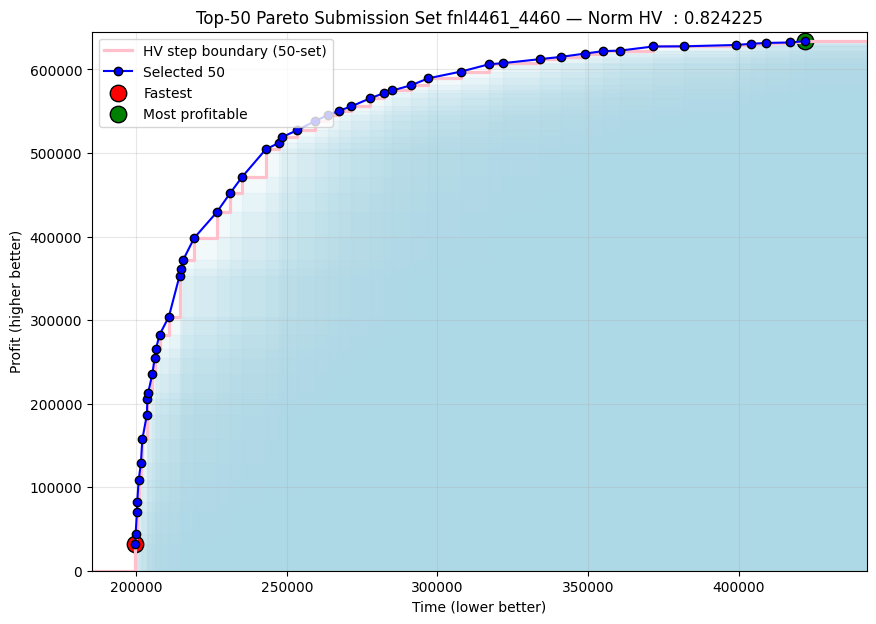

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ================== USE SUBMISSION SET ==================
# not archive_objs — only final 50 exported points
pts = np.array([(t,p,g) for (t,p,w,g) in final_objs])
pts = pts[pts[:,0].argsort()]  # sort by time

times   = pts[:,0]
profits = pts[:,1]

T_min, T_max = IDEAL[0], NADIR[0]
P_min, P_max = 0, 645_150.0

plt.figure(figsize=(10,7))

# -------------------------------------------------
#  Dominated area shading for the displayed 20 only
# -------------------------------------------------
for i in range(len(times)):
    xs = [times[i], T_max, T_max, times[i]]
    ys = [P_min, P_min, profits[i], profits[i]]
    plt.fill(xs, ys, color="lightblue", alpha=0.15)

# -------------------------------------------------
# Hypervolume boundary (step front)
# -------------------------------------------------
hv_x = [T_min]
hv_y = [P_min]

for t,p in zip(times, profits):
    hv_x += [t, t]
    hv_y += [hv_y[-1], p]

hv_x.append(T_max)
hv_y.append(hv_y[-1])

plt.plot(hv_x, hv_y, color="pink", linewidth=2.3,
         label="HV step boundary (50-set)")

# -------------------------------------------------
# Pareto front scatter
# -------------------------------------------------
plt.plot(times, profits, "-o", color="blue", markersize=6,
         markeredgecolor="black", label="Selected 50")

# Best markers
best_t = np.argmin(times)
best_p = np.argmax(profits)

plt.scatter(times[best_t], profits[best_t], s=140,
            color="red", edgecolor="black", label="Fastest")
plt.scatter(times[best_p], profits[best_p], s=140,
            color="green", edgecolor="black", label="Most profitable")

plt.xlim(T_min, T_max)
plt.ylim(P_min, P_max)
plt.grid(alpha=0.3)
plt.xlabel("Time (lower better)")
plt.ylabel("Profit (higher better)")
plt.title(f"Top-50 Pareto Submission Set fnl4461_4460 — Norm HV  : {hv_norm_nd:.6f}")
plt.legend()
plt.show()
